# Astrophysical simulation of BBHs 
### P. Ajith, 2018-02-06

In [1]:
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt 
import corner as crn
import simulate_injections as sim_inj
from cosmology_models import LCDM
from scipy import stats
from scipy.optimize import fsolve
lcdm = LCDM(Om0=0.3)
import lalinspiral.sbank.psds as psds
import phenomhh as phh
import lal, lalsimulation as lalsim
import plotsettings

/Users/pajith/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Simulate a population of BBH systems

In [2]:
# parameters  
N_sim = int(1e5)                              # number of simulations
z_dist_model = 'Dominik'                      # model used for the z-distribution of mergers 
mass_dist_model = 'Powerlaw1'                 # model for mass distribution 
z_s, m1_s, m2_s = sim_inj.generate_z_m_samples(N_sim, z_dist_model, mass_pdf_model=mass_dist_model)  # sourcemasses and redshift 
a1_s = np.random.uniform(0,1,N_sim)           # primary dimensionlesspin 
a2_s = np.random.uniform(0,1,N_sim)           # primary dimensionlesspin 
cos_iota_s = np.random.uniform(-1, 1, N_sim)  # cosine of the inclination angle 
phi0_s = np.random.uniform(0, 2*np.pi, N_sim) # initial phase 
psi_s = np.random.uniform(0, 2*np.pi, N_sim)  # polarization angle 
cos_theta_s = np.random.uniform(-1, 1, N_sim) # sky location - polar 
phi_s = np.random.uniform(0, 2*np.pi, N_sim)  # sky location - azimuth

# compute redshifted masses 
m1_z, m2_z = m1_s*(1+z_s), m2_s*(1+z_s)

# total mass and mass ratio 
M_s = m1_s+m2_s
M_z = m1_z+m2_z
q = m1_z/m2_z
idx = np.where(q < 1.)
q[idx] = 1./q[idx]   # use convention q > 1 

# calculate luminosity distance to the source (Mpc)
dC_s = np.vectorize(lcdm.comoving_distance_z)(z_s)
dL_s = dC_s*(1+z_s)

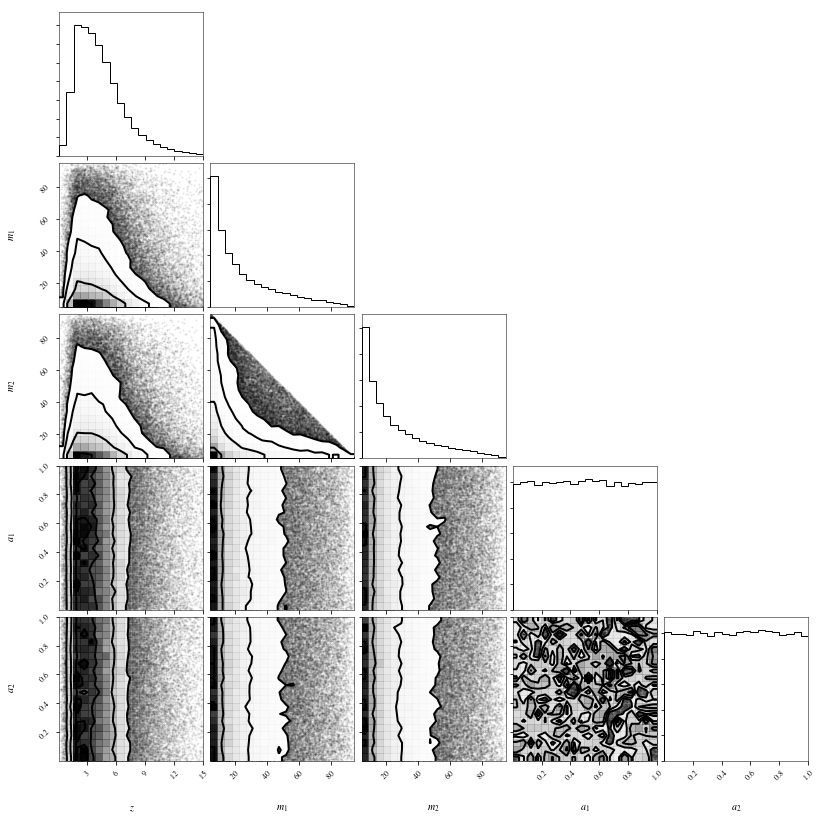

In [3]:
# corner plots of the intrinsic parameters and redshift 
plt.figure()
crn.corner(np.column_stack([z_s, m1_s, m2_s, a1_s, a2_s]),labels=['$z$','$m_1$','$m_2$','$a_1$','$a_2$'])
plt.show()

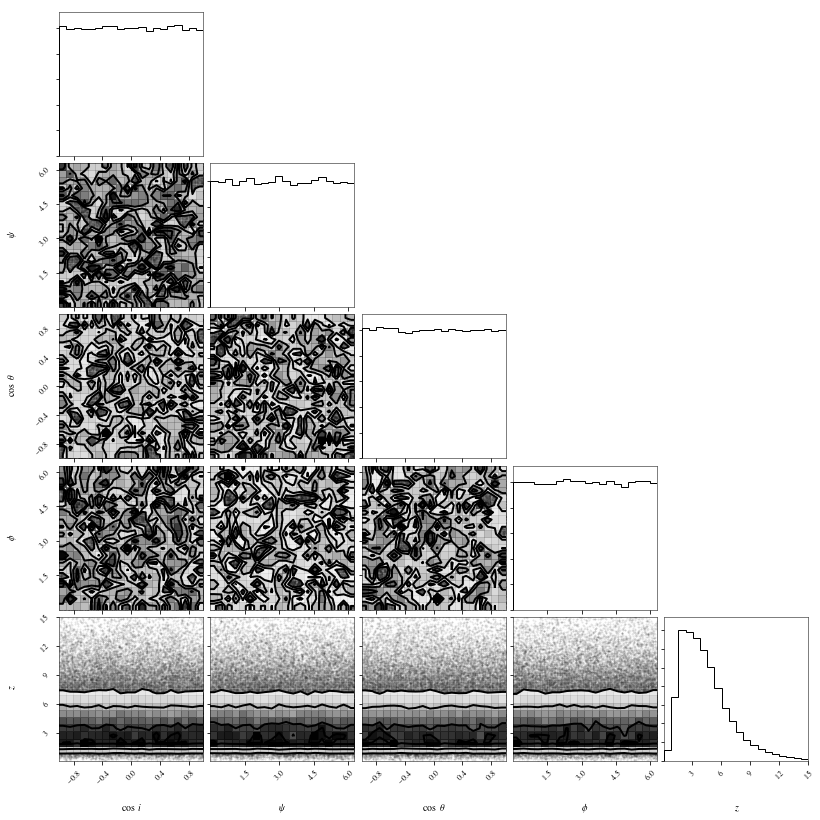

In [4]:
# corner plots of the extrinsic parameters
plt.figure()
crn.corner(np.column_stack([cos_iota_s, psi_s, cos_theta_s, phi_s, z_s]),labels=['cos $i$','$\psi$','$\cos~\\theta$','$\phi$','$z$'])
plt.show()

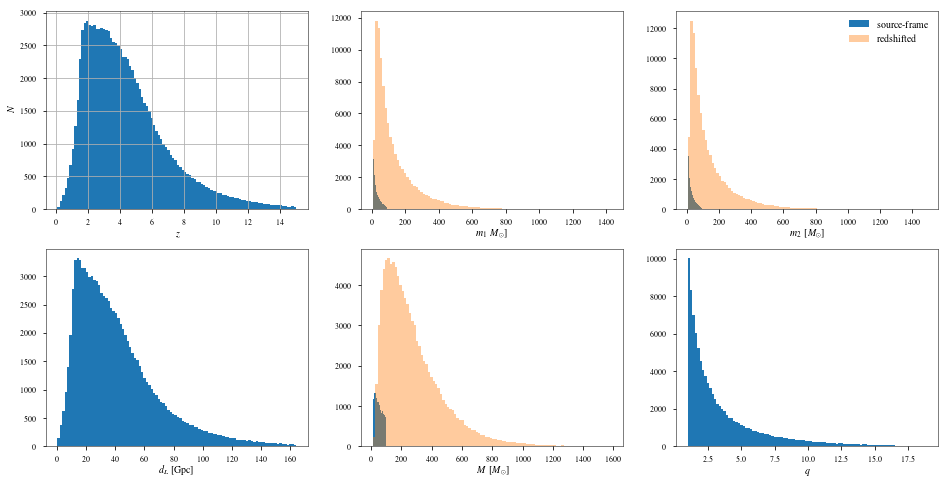

In [5]:
# histograms of m1, m2, z with more detail 
plt.figure(figsize=(16,8))
plt.subplot(231)
plt.hist(z_s,100)
plt.grid()
plt.xlabel('$z$')
plt.ylabel('$N$')
plt.subplot(232)
plt.hist(m1_s,100)
plt.hist(m1_z,100, alpha=0.4)
plt.xlabel('$m_1 \ M_\odot]$')
plt.subplot(233)
plt.hist(m2_s,100, label='source-frame')
plt.hist(m2_z,100, alpha=0.4, label='redshifted')
plt.xlabel('$m_2 \ [M_\odot]$')
plt.legend(frameon=False)
plt.subplot(234)
plt.hist(dL_s/1e3,100)
plt.xlabel('$d_L$ [Gpc]')
plt.subplot(235)
plt.hist(M_s,100)
plt.hist(M_z,100, alpha=0.4)
plt.xlabel('$M \ [M_\odot]$')
plt.subplot(236)
plt.hist(q,100, label='source-frame')
plt.xlabel('$q$')
plt.show()

## Compute SNR 

In [6]:
# antenna patters 
Fp = 0.5*(1 + cos_theta_s**2)*np.cos(2*phi_s)*np.cos(2*psi_s) - cos_theta_s*np.sin(2*phi_s)*np.sin(2*psi_s)
Fc = 0.5*(1 + cos_theta_s**2)*np.cos(2*phi_s)*np.sin(2*psi_s) + cos_theta_s*np.sin(2*phi_s)*np.cos(2*psi_s)

In [7]:
# parameters for SNR computation 
snr = np.zeros_like(m1_s)
f_low = 10.
f_max = 1024.
N = 16385
f = np.linspace(0, f_max, N)
df = np.mean(np.diff(f))
approx = 'IMRPhenomPv2'
approx_enum = lalsim.GetApproximantFromString(approx)
Sh = psds.noise_models['aLIGOZeroDetHighPower'](f)
band_idx = f >= f_low 

/Users/pajith/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2652: RuntimeWarning: divide by zero encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/Users/pajith/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2652: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [8]:
for i in range(N_sim):
    
    # calculate SNR if the signal is in the freq band and if the binary is reasonably close (z < 3)
    f_cut = 0.1/(m1_z[i]+m2_z[i])/lal.MTSUN_SI   
    if f_cut > f_low+10 and z_s[i] < 3.:
            
        # generate waveforms 
        hp, hc = lalsim.SimInspiralChooseFDWaveform(phi0_s[i], df, m1_z[i]*lal.MSUN_SI, m2_z[i]*lal.MSUN_SI,\
                                            0, 0, 0, 0, 0, 0, f_low, f_max, f_low, dL_s[i]*1e6*lal.PC_SI, \
                                            np.arccos(cos_iota_s[i]), 0, 0, None, None, -1, -1, \
                                            approx_enum)

        # form strain signal in detector
        hf = Fp[i]*hp.data.data + Fc[i]*hc.data.data

        # compute SNR 
        snr[i] = 2*np.sqrt(df*np.sum(abs(hf[band_idx])**2/Sh[band_idx]))

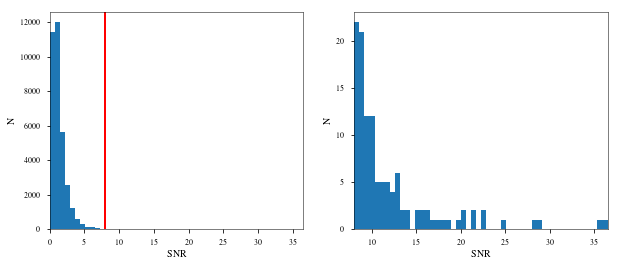

In [9]:
# detected events 
snr_thresh = 8 
det_idx = np.where(snr >= snr_thresh)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(snr[snr>0],50)
plt.axvline(x=snr_thresh, color='r')
plt.xlabel('SNR')
plt.ylabel('N')
plt.xlim(min(snr), max(snr))
plt.subplot(122)
plt.hist(snr[det_idx],50)
plt.xlim(snr_thresh, max(snr))
plt.xlabel('SNR')
plt.ylabel('N')
plt.show()

## Distributions of parameters of detected signals 

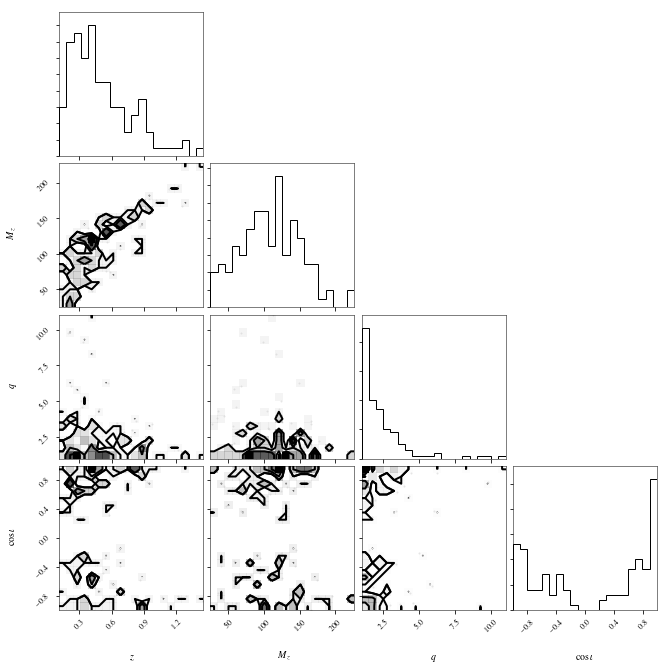

In [10]:
# corner plots of the intrinsic parameters and redshift 
plt.figure()
crn.corner(np.column_stack([z_s[det_idx], M_z[det_idx], q[det_idx], \
                            cos_iota_s[det_idx]]),labels=['$z$','$M_z$','$q$','$\cos \iota$'])
plt.show()

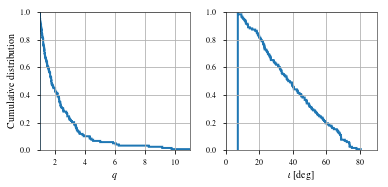

In [11]:
# limit iota between 0 and pi/2 
iota = np.arccos(cos_iota_s) 
ref_idx = np.where(iota > np.pi/2.)
iota[ref_idx] = np.pi-iota[ref_idx]

# plot the cumulative distributions of q and cos_iota           
plt.figure(figsize=(5.5,2.7))
plt.subplot(121)
plt.hist(q[det_idx],1000, cumulative=-1, normed=True, histtype=u'step', lw=2)
plt.xlabel('$q$')
plt.ylabel('Cumulative distribution')
plt.xlim(1,max(q[det_idx]))
plt.grid()
plt.ylim(0,1)
plt.subplot(122)
plt.hist(iota[det_idx]*180/np.pi,1000, cumulative=-1, normed=True, histtype=u'step', lw=2)
plt.xlabel('$\iota$ [deg]')
plt.xlim(0,90)
plt.ylim(0,1)
plt.grid()
plt.tight_layout()
plt.savefig('q_and_iota_dist_z_dist_%s_mass_dist_%s_snrthresh_%d.pdf' %(z_dist_model, mass_dist_model, snr_thresh))
plt.show()

In [12]:
# save the simulation results 
np.savetxt('sim_results_detected_z_dist_%s_mass_dist_%s.dat.gz' %(z_dist_model, mass_dist_model), \
           np.column_stack([z_s[det_idx], m1_s[det_idx], m2_s[det_idx], cos_iota_s[det_idx], snr[det_idx]]), header='z_s m1_s m2_s cos_iota_s snr')